In [1]:
#!pip install tensorflow==2.8.0

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import operator
import tensorflow as tf
tf.__version__

'2.8.0'

In [3]:
model_files = ['modelo_01_expressoes.h5', 'modelo_02_expressoes.h5', 
               'modelo_03_expressoes.h5', 'modelo_04_expressoes.h5',
               'modelo_05_expressoes.h5']
models = {} # dicionario que irá mapear o modelo à sua acurácia

x_test = np.load('/kaggle/input/arquivos-card-20/Material/mod_xtest.npy')
y_test = np.load('/kaggle/input/arquivos-card-20/Material/mod_ytest.npy')

for model in model_files:
    # carrega o modelo:
    loaded_mod = load_model('/kaggle/input/arquivos-card-20/Material/' + model)

    #calcula acurárcia e perda do modelo para os conjuntos de teste:
    scores = loaded_mod.evaluate(np.array(x_test), np.array(y_test), batch_size=64)

    # imprimindo os resultados:
    print('------' + str(model) + '------')
    print('Loss: ' + str(scores[0]))
    print('Accuracy: ' + str(scores[1]))
    models[model] = str(scores[1]) # adiciona o modelo com sua acurácia no dicionário
    print('\n')

57/57 [==============================] - 17s 293ms/step - loss: 1.0704 - accuracy: 0.6392
------modelo_01_expressoes.h5------
Loss: 1.070416808128357
Accuracy: 0.6391752362251282


57/57 [==============================] - 8s 135ms/step - loss: 1.0119 - accuracy: 0.6411
------modelo_02_expressoes.h5------
Loss: 1.0118968486785889
Accuracy: 0.6411256790161133


57/57 [==============================] - 15s 265ms/step - loss: 1.0732 - accuracy: 0.6308
------modelo_03_expressoes.h5------
Loss: 1.0731695890426636
Accuracy: 0.6308164000511169


57/57 [==============================] - 24s 415ms/step - loss: 1.1691 - accuracy: 0.6160
------modelo_04_expressoes.h5------
Loss: 1.169052004814148
Accuracy: 0.61604905128479


57/57 [==============================] - 17s 289ms/step - loss: 1.8206 - accuracy: 0.2455
------modelo_05_expressoes.h5------
Loss: 1.820610761642456
Accuracy: 0.2454722821712494




In [4]:
# ordena os modelos em ordem descrescente pela precisão:
order_models = sorted(models.items(), key=operator.itemgetter(1), reverse=True)
print(order_models)

[('modelo_02_expressoes.h5', '0.6411256790161133'), ('modelo_01_expressoes.h5', '0.6391752362251282'), ('modelo_03_expressoes.h5', '0.6308164000511169'), ('modelo_04_expressoes.h5', '0.61604905128479'), ('modelo_05_expressoes.h5', '0.2454722821712494')]


In [8]:
order_models[0] # imprime o melhor modelo

('modelo_02_expressoes.h5', '0.6411256790161133')

# Teste com o melhor modelo

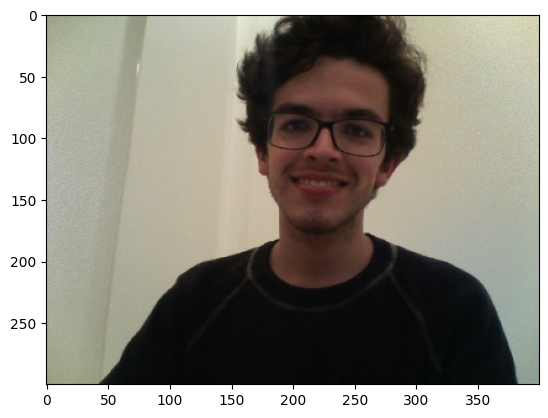

In [6]:
image = cv2.imread('/kaggle/input/arquivos-card-20/Material/testes/teste_gabriel.png')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [10]:
# caminho para o modelo de detecção de faces (de ROIs):
cascade_faces = '/kaggle/input/arquivos-card-20/Material/haarcascade_frontalface_default.xml'
# caminho para o melhor classificador:
model_path = '/kaggle/input/arquivos-card-20/Material/' + order_models[0][0]

face_detec = cv2.CascadeClassifier(cascade_faces) # carrega o modelo para extração de ROIs
emotion_classifier = load_model(model_path, compile=False) # carrega o modelo classificador

# labels:
emotions = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']

[1.2285657e-03 8.9724279e-05 7.5628090e-04 9.4787621e-01 2.9239706e-03
 5.5896194e-04 4.6566237e-02]


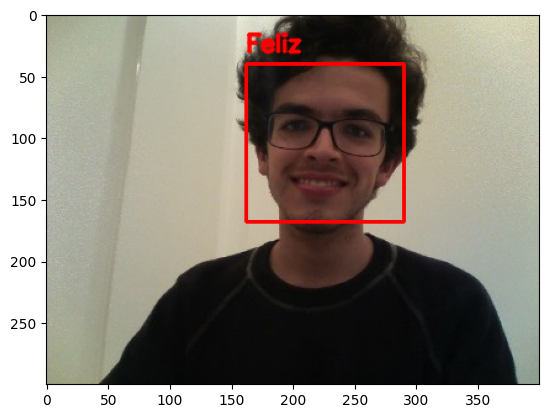

In [12]:
from tensorflow.keras.preprocessing.image import img_to_array

original = image.copy() # copia a imagem original
# aplica o face detector na imagem:
faces = face_detec.detectMultiScale(original, scaleFactor=1.1,
                                    minNeighbors=3, minSize=(20,20))
# cria uma versão em cinza da imagem, pois é assim que o classificador funciona:
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# loop para predição e adição de texto e retângulo na imagem:
if len(faces) > 0: # se pelo menos 1 face foi detectada
    for (x, y, w, h) in faces: # dimensoes que definem a ROI
        roi = gray[y: y+h, x: x+w] # extrai a ROI da imagem em cinza
        roi = cv2.resize(roi, (48, 48)) # redimensiona a ROI para o que exige o classificador
        roi = roi.astype('float') / 255. # converte para float e normaliza
        roi = img_to_array(roi) # converte para array e add dimensão de cor
        roi = np.expand_dims(roi, axis=0) # add dimensão de batch
        preds = emotion_classifier.predict(roi)[0] # faz a previsão e extrai o array de probs
        print(preds)
        emotion_prob = np.max(preds) # extrai a maior prob
        label = emotions[preds.argmax()] # extrai a label da maior prob
        cv2.putText(original, # na imagem original
                    label, # texto é a label da roi extraída
                    (x, y-10), # local (esquerda superior da face)
                    cv2.FONT_HERSHEY_SIMPLEX, # fonte
                    0.65, # tamanho da fonte
                    (0, 0, 255), # cor em BGR (vermelha)
                    2,
                    cv2.LINE_AA) # tipo de linha
        cv2.rectangle(original, # na imagem original
                      (x, y), # começando na esquerda superior da ROI
                      (x+w, y+h), # terminando na direita inferior
                      (0, 0, 255), # cor em BGR (vermelho)
                      2) # espessura da linha
else:
    print('No face detected.')

plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))